### 1. Important imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_squared_error


### 2. Import data

In [3]:
df = pd.read_csv('GDPIndia.csv', parse_dates=True)
series = df.copy()
df = df.rename(columns={'GDPpercapita': 'GDP'})

X = df["GDP"]
Y = df["Year"]

# df.columns
# df.head()
# df.describe()

### 3. Plot data for visualization

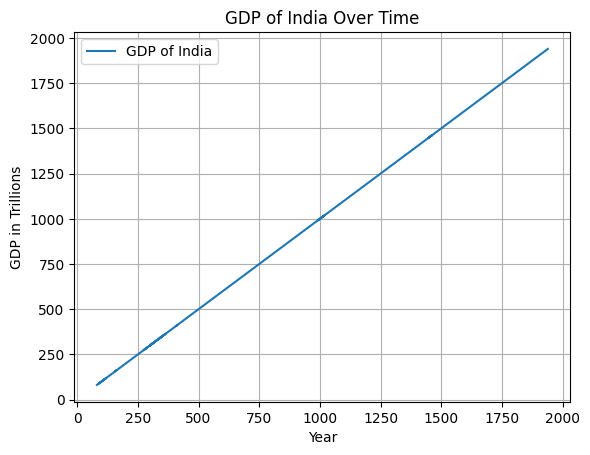

In [4]:
plt.plot(X, X, label='GDP of India')
plt.xlabel('Year')
plt.ylabel('GDP in Trillions')
plt.title('GDP of India Over Time')
plt.legend()
plt.grid()
plt.show()

### 4. Use Dickey Fuller test to check if dataset is stationary or not!
The dataset is not stationary: 
<br/>The p-value (1.00) is much greater than any common significance level (e.g., 0.05 or 0.10). This means we fail to reject the null hypothesis of the Dickey-Fuller test, which states that the time series is non-stationary. Additionally, the Test Statistic (5.08) is not less than the critical values, further supporting non-stationarity.
<br/>
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [5]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items(): # type: ignore #ignore
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(df['GDP'])

Results of Dickey-Fuller Test:
Test Statistic                  5.083669
p-value                         1.000000
#Lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


### 5. To find value of p, we are performing first differencing and then run Dickey Fuller test

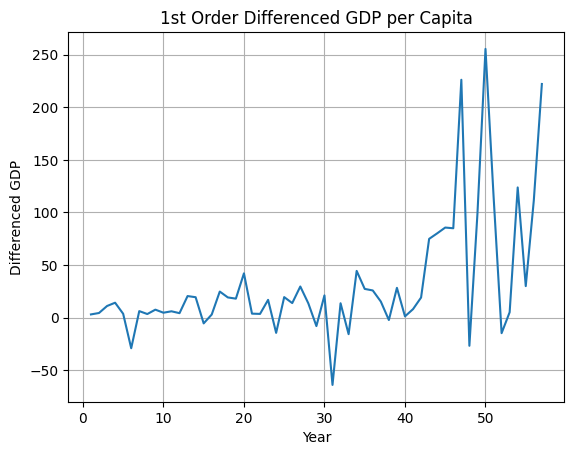

Results of Dickey-Fuller Test:
Test Statistic                 -0.319971
p-value                         0.922628
#Lags Used                      6.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


In [7]:
# Apply first differencing
df['GDP_diff'] = df['GDP'].diff()

df_diff = df.dropna()


plt.plot(df_diff['GDP_diff'])
plt.title('1st Order Differenced GDP per Capita')
plt.xlabel('Year')
plt.ylabel('Differenced GDP')
plt.grid(True)
plt.show()

adf_test(df_diff['GDP_diff'])

### 6. Since <b> p-value </b> is 0.9. So, performing second differencing and then run Dickey Fuller test

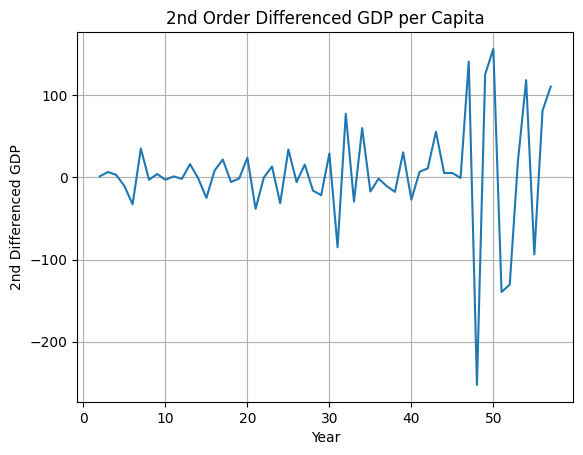

Results of Dickey-Fuller Test:
Test Statistic                 -5.029776
p-value                         0.000019
#Lags Used                      5.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


In [9]:
# Apply second differencing
df['GDP_diff2'] = df['GDP_diff'].diff()

df_diff2 = df.dropna()

plt.plot(df_diff2['GDP_diff2'])
plt.title('2nd Order Differenced GDP per Capita')
plt.xlabel('Year')
plt.ylabel('2nd Differenced GDP')
plt.grid(True)
plt.show()

adf_test(df_diff2['GDP_diff2'])

<i>As now p value is less than 0.05 or 0.10 so we can consider p value as 2!</i>
<br />
### 7. Calculate rolling mean to check if data is stationary or not

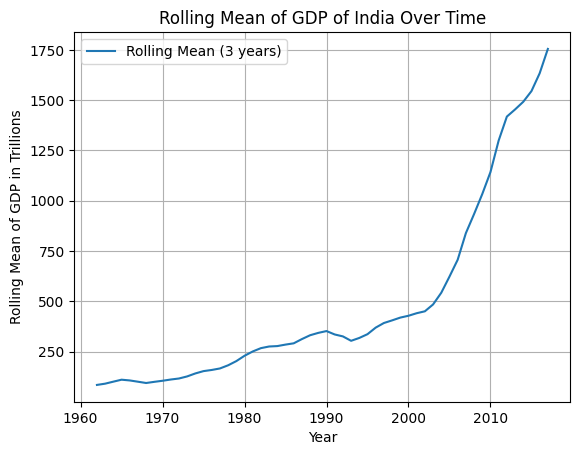

In [20]:
# Instead of using adfuuller test to see if data is stationary or not, we can use rolling mean to see if data is stationary or not
# If rolling mean is constant then data is stationary, otherwise not
# Here we are using 3 years rolling mean to see if data is stationary or not
# We can also replace column_names with GDP_diff, GDP_diff2 to see the difference in graph
rolling_mean = df["GDP"].rolling(window=3).mean()
plt.plot(Y, rolling_mean, label='Rolling Mean (3 years)')
plt.xlabel('Year')
plt.ylabel('Rolling Mean of GDP in Trillions')
plt.title('Rolling Mean of GDP of India Over Time')
plt.legend()
plt.grid()
plt.show()

### 8.  Identify ARIMA Parameters (p and q)

Use ACF (Autocorrelation Function) → Helps determine q.

Use PACF (Partial Autocorrelation Function) → Helps determine p.

✅ From the ACF plot:
There is one significant spike at lag 1, then the rest are within the confidence bounds (shaded area).

This suggests a Moving Average component of order 1:
→ q = 1

✅ From the PACF plot:
There is one clear spike at lag 1, then a quick drop-off.

This suggests an Autoregressive component of order 1:
→ p = 1

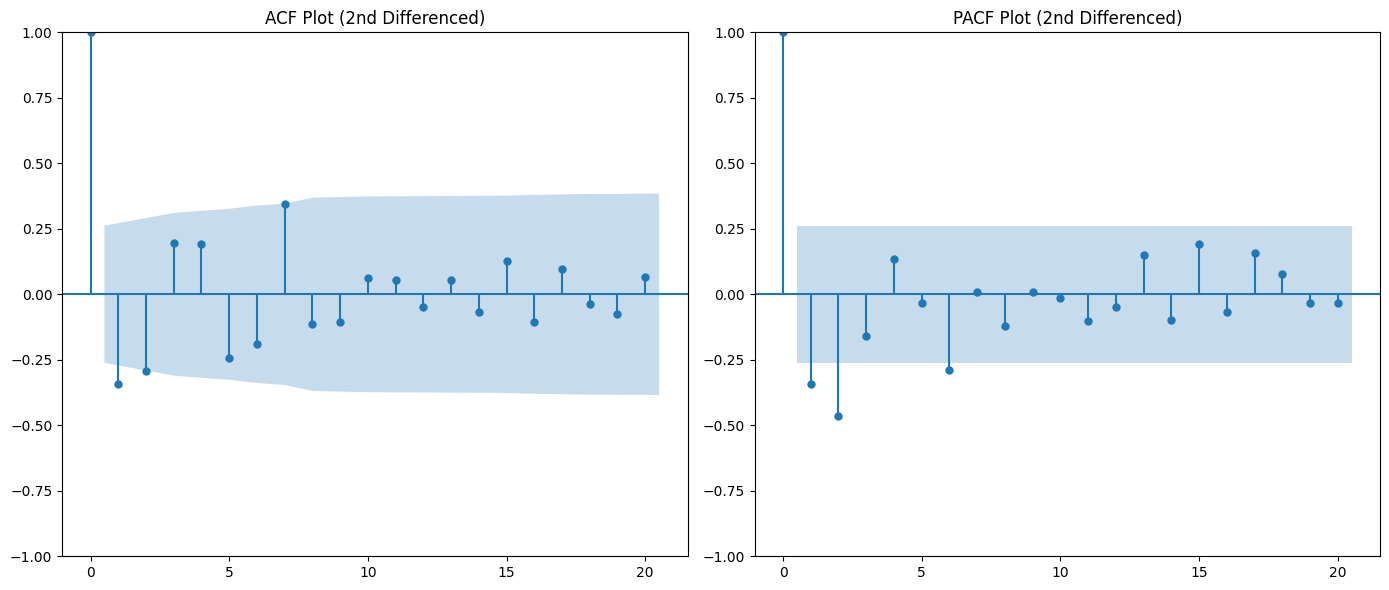

In [ ]:
plt.figure(figsize=(14, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(df_diff2['GDP_diff2'], ax=plt.gca(), lags=20)
plt.title('ACF Plot (2nd Differenced)')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(df_diff2['GDP_diff2'], ax=plt.gca(), lags=20, method='ywm')
plt.title('PACF Plot (2nd Differenced)')

plt.tight_layout()
plt.show()


### 9. Fit ARIMA Model

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   58
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -301.753
Date:                Mon, 30 Jun 2025   AIC                            609.505
Time:                        11:06:43   BIC                            615.581
Sample:                             0   HQIC                           611.861
                                 - 58                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0358      0.143      0.249      0.803      -0.245       0.317
ma.L1         -0.8035      0.067    -11.993      0.000      -0.935      -0.672
sigma2      2756.2266    309.248      8.913      0.0

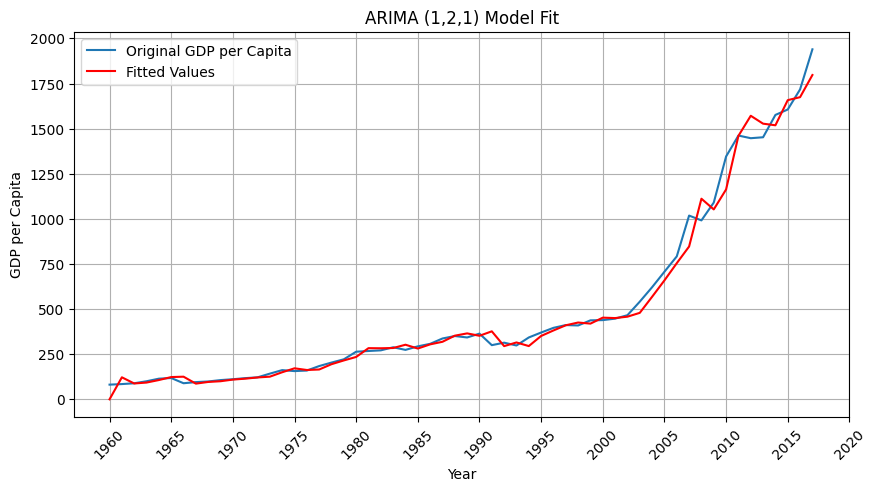

In [27]:
# Fit ARIMA model (p=1, d=2, q=1)
model = ARIMA(df['GDP'], order=(1, 2, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot actual vs. fitted values
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['GDP'], label='Original GDP per Capita')
plt.plot(df['Year'], model_fit.fittedvalues, label='Fitted Values', color='red')

# Set x-axis ticks to 5-year intervals
min_year = df['Year'].min()
start_year = min_year - (min_year % 5)  # Round down to nearest 5
tick_years = np.arange(start_year, df['Year'].max() + 5, 5)
plt.gca().set_xticks(tick_years)
plt.gca().set_xticklabels(tick_years, rotation=45)

plt.title('ARIMA (1,2,1) Model Fit')
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.legend()
plt.grid(True)
plt.show()

### 10. Forecasting

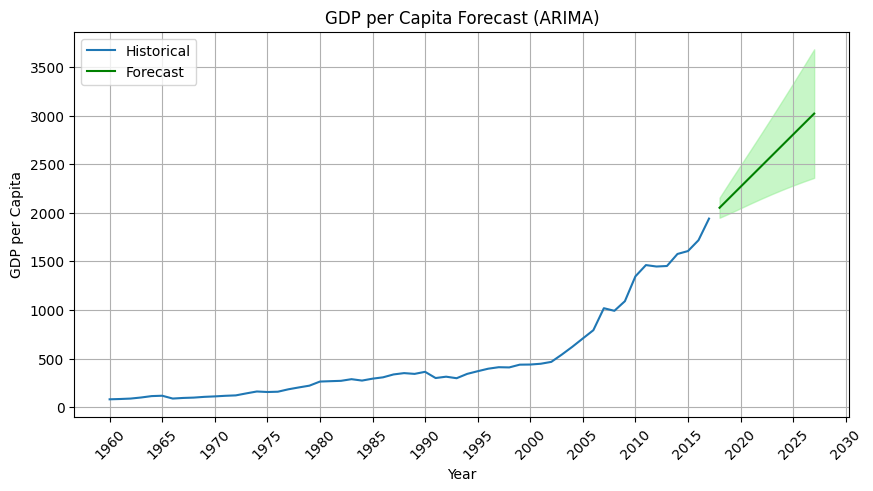

In [29]:
# Forecast next 10 years
forecast = model_fit.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

last_year = df['Year'].iloc[-1]
forecast_years = [last_year + i for i in range(1, 11)]  

all_years = list(df['Year']) + forecast_years

plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['GDP'], label='Historical')
plt.plot(forecast_years, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_years, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.5)

min_year = min(all_years)
max_year = max(all_years)
start_year = min_year - (min_year % 5)
tick_years = np.arange(start_year, max_year + 5, 5)

plt.gca().set_xticks(tick_years)  
plt.gca().set_xticklabels(tick_years, rotation=45)
plt.title('GDP per Capita Forecast (ARIMA)')
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.legend()
plt.grid(True)

plt.show()

In [13]:
# pip install scipy==1.15.3

### 11. Use auto_arima to find best p, d, and q parameters

In [31]:
warnings.filterwarnings("ignore")
model = auto_arima(
    df['GDP'],                 # The time series data
    seasonal=False,            # Use seasonal=True if there's seasonality
    stepwise=True,             # Faster search
    suppress_warnings=True,    # Suppress warnings
    trace=True                 # Show progress
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=608.980, Time=1.75 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=630.216, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=624.969, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=607.081, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=628.419, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=608.945, Time=1.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=608.768, Time=1.27 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=607.553, Time=0.22 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 6.286 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -300.540
Date:                Mon, 30 Jun 2025   AIC                   

### 12. Fit the model with best params

In [32]:
model = ARIMA(df['GDP'], order=(0, 2, 1), trend='n') 
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   58
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -301.776
Date:                Mon, 30 Jun 2025   AIC                            607.553
Time:                        11:11:09   BIC                            611.604
Sample:                             0   HQIC                           609.123
                                 - 58                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7944      0.050    -15.936      0.000      -0.892      -0.697
sigma2      2757.7511    308.125      8.950      0.000    2153.836    3361.666
Ljung-Box (L1) (Q):                   0.01   Jarque-

### 13. Calculate MSE to find best params

In [ ]:
n_splits = 5
horizon = 5  
errors = []

for i in range(n_splits):
    train_end = len(df) - (n_splits - i) * horizon
    train_data = df['GDP'].iloc[:train_end]
    test_data = df['GDP'].iloc[train_end:train_end + horizon]

    # Fit model     
    model = ARIMA(train_data, order=(1, 2, 1), trend='n')
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=horizon)

    # Calculate error
    error = mean_squared_error(test_data, forecast)
    errors.append(error)

    print(f"Fold {i+1}: MSE = {error:.2f}")

# Average error across folds
print(f"\nAverage MSE over {n_splits} folds: {np.mean(errors):.2f}")


Fold 1: MSE = 1723.44
Fold 2: MSE = 60.59
Fold 3: MSE = 82041.94
Fold 4: MSE = 86660.63
Fold 5: MSE = 7048.34

Average MSE over 5 folds: 35506.99


ToDo:
    Residuals,
    Covariance